## Kinder Delta

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
# import itertools
import geopandas as gpd
import warnings

from shapely.geometry import Point
from scipy import stats

warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['retina']


In [40]:
all_files = glob.glob('data/foresets/*.asc')

lines = []

for file in all_files:
    
    df = pd.read_csv(file, delimiter = '\t', names = ['X', 'Y', 'Z'])
    df = df.sort_values(by = 'Z', ascending = False, ignore_index = True)
    
    geometry = [Point(xy) for xy in zip(df.X, df.Y)]
    df['geometry'] = geometry
    df = df.set_geometry('geometry')
    df.crs = {'init': 'epsg:27700'}
    df.to_crs(epsg = 27700, inplace = True)
    
    df['dist'] = np.cumsum(df.distance(df.shift()))
    df.replace(np.nan, 0, inplace = True)
    
    lines.append(df)

In [41]:
geo_map = gpd.read_file('shp/kinder_map.shp')
geo_map.to_crs(epsg = 27700, inplace = True)
geo = geo_map[geo_map.LEX_D.str.contains('KINDERSCOUT')]

[(5302.6222, 5894.6791), (7819.0931, 8043.6279)]

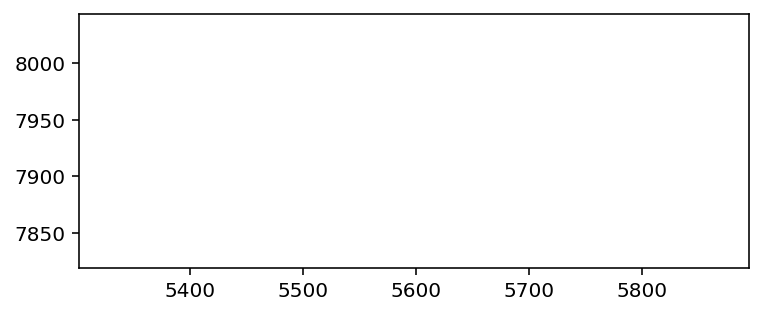

In [43]:
fig, ax = plt.subplots()

geo.plot(ax = ax)

ax.set(xlim = (lines[10].geometry.x.min() - 200, lines[10].geometry.x.max() + 300),
               ylim = (lines[10].geometry.y.min() - 100, lines[10].geometry.y.max() + 100))

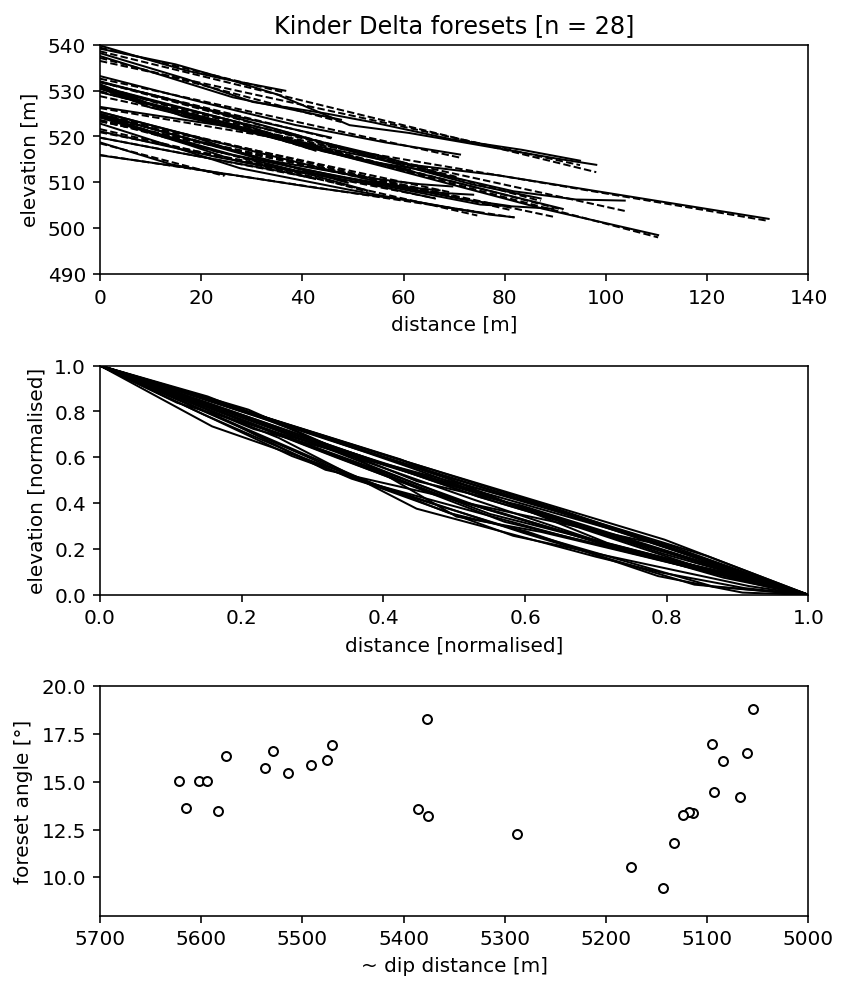

In [20]:
fig, ax = plt.subplots(figsize = (6, 7), nrows = 3)

degrees_list = []
xmax_list = []

for i in range(len(lines)):
    
    df = lines[i]
    
    ##########
    
    ax[0].plot(df.dist, df.Z, c = 'k', lw = 1)
    ax[0].set(xlim = (0, 140), xlabel = 'distance [m]', ylim = (490, 540),  
              ylabel = 'elevation [m]', title = f'Kinder Delta foresets [n = {len(lines)}]')
    
    reg = stats.linregress(df.dist, df.Z)
    ax[0].plot(df.dist, reg.slope * df.dist + reg.intercept, c = 'k', linestyle = 'dashed', lw = 1)

    ##########

    norm_z = (df.Z - min(df.Z)) / ((max(df.Z)) - min(df.Z))
    norm_dist = (df.dist - min(df.dist)) / ((max(df.dist)) - min(df.dist))

    ax[1].plot(norm_dist, norm_z, c = 'k', lw = 1)
    ax[1].set(xlim = (0, 1), ylim = (0, 1), xlabel = 'distance [normalised]', 
              ylabel = 'elevation [normalised]')

    ##########

    angle = np.arctan(reg.slope) # slope angle in radians
    degrees = np.rad2deg(angle) # slope angle in degrees
        
    ax[2].scatter(df.X.max(), y = degrees * -1, color = 'w', edgecolor = 'k', s = 20)
    ax[2].set(ylim = (8, 20), xlim = (5700, 5000), xlabel = '~ dip distance [m]', ylabel = 'foreset angle [Â°]')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111, projection='3d')

for i, c in zip(range(len(lines)), color):
    
    df = lines[i]
    ax.plot_trisurf(df.X, df.Y, df.Z, color='white', edgecolors='grey', alpha=0.5)
    ax.scatter(df.X, df.Y, df.Z, c='red')
    ax.set_xlim(5700, 5000)
    ax.set_ylim(7960, 7860)
    ax.view_init(elev=20., azim=30)

